<a href="https://colab.research.google.com/github/luthierman/quantum-research/blob/main/quantum_research_experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

DEPENDENCY INSTALLATIONS (mostly for colab)

In [ ]:
# !pip install tensorflow-gpu==2.3.1
# !pip install tensorflow-quantum
# !pip install gym
# !pip tensorboard_plugin_profile==2.3.0
# https://github.com/qulacs/cirq-qulacs.git for gpu

%%bash
# install required system dependencies
apt-get install -y xvfb x11-utils
# install required python dependencies
pip install gym[box2d]==0.17.* \
            pyvirtualdisplay==0.2.* \
            PyOpenGL==3.1.* \
            PyOpenGL-accelerate==3.1.* \
            tensorflow-quantum \
            tensorflow-gpu==2.3.1 \
            imageio==2.4.0 \
            PILLOW \
            pyglet==1.3.2


Reading package lists...
Building dependency tree...
Reading state information...
x11-utils is already the newest version (7.7+3build1).
xvfb is already the newest version (2:1.19.6-1ubuntu4.8).
0 upgraded, 0 newly installed, 0 to remove and 30 not upgraded.
Processing /root/.cache/pip/wheels/05/31/54/501ff9f64e6084bbcb75e600f257f3c628b19f0eaadc37162d/gym-0.17.3-cp37-none-any.whl
  Found existing installation: gym 0.10.11
    Uninstalling gym-0.10.11:
      Successfully uninstalled gym-0.10.11


ERROR: gym 0.17.3 has requirement pyglet<=1.5.0,>=1.4.0, but you'll have pyglet 1.3.2 which is incompatible.


In [ ]:
!sudo apt-get install -y xvfb ffmpeg x11-utils
!pip install -q 'gym==0.10.11'
!pip install -q 'imageio==2.4.0'
!pip install -q PILLOW
!pip install -q 'pyglet==1.3.2'
!pip install -q pyvirtualdisplay

Reading package lists... Done
Building dependency tree       
Reading state information... Done
x11-utils is already the newest version (7.7+3build1).
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
xvfb is already the newest version (2:1.19.6-1ubuntu4.8).
0 upgraded, 0 newly installed, 0 to remove and 30 not upgraded.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


FOR EMBEDDING VIDEO IN CELL

In [ ]:
import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import pyvirtualdisplay


_display = pyvirtualdisplay.Display(visible=False,  # use False with Xvfb
                                    size=(1400, 900))
_ = _display.start()
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

FOR RECORDING SCORES OF MODELS

In [ ]:
from statistics import mean
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from collections import deque
import os
import csv
import numpy as np


class ScoreLogger:
    def __init__(self, path, env_name):
        
        self.env_name = env_name
        self.path = path
        self.SCORES_CSV_PATH = "{}/scores.csv".format(self.path)
        self.SCORES_PNG_PATH = "{}/scores.png".format(self.path)
        self.SOLVED_CSV_PATH = "{}/solved.csv".format(self.path)
        self.SOLVED_PNG_PATH = "{}/solved.csv".format(self.path)
        self.AVERAGE_SCORE_TO_SOLVE = 195
        self.CONSECUTIVE_RUNS_TO_SOLVE = 100
        self.scores = deque(maxlen=self.CONSECUTIVE_RUNS_TO_SOLVE)
        if os.path.exists(self.SCORES_PNG_PATH):
            os.remove(self.SCORES_PNG_PATH)
        if os.path.exists(self.SCORES_CSV_PATH):
            os.remove(self.SCORES_CSV_PATH)

    def add_score(self, score, run):
        self._save_csv(self.SCORES_CSV_PATH, score)
        self._save_png(input_path=self.SCORES_CSV_PATH,
                       output_path=self.SCORES_PNG_PATH,
                       x_label="runs",
                       y_label="scores",
                       average_of_n_last=self.CONSECUTIVE_RUNS_TO_SOLVE,
                       show_goal=True,
                       show_trend=True,
                       show_legend=True)
        self.scores.append(score)
        mean_score = mean(self.scores)
        print ("Scores: (min: " + str(min(self.scores)) + ", avg: " + str(mean_score) + ", max: " + str(max(self.scores)) + ")\n")
        if mean_score >= self.AVERAGE_SCORE_TO_SOLVE and len(self.scores) >= self.CONSECUTIVE_RUNS_TO_SOLVE:
            solve_score = run-self.CONSECUTIVE_RUNS_TO_SOLVE
            print ("Solved in " + str(solve_score) + " runs, " + str(run) + " total runs.")
            self._save_csv(self.SOLVED_CSV_PATH, solve_score)
            self._save_png(input_path=self.SOLVED_CSV_PATH,
                           output_path=self.SOLVED_PNG_PATH,
                           x_label="trials",
                           y_label="steps before solve",
                           average_of_n_last=None,
                           show_goal=False,
                           show_trend=False,
                           show_legend=False)
            exit()

    def _save_png(self, input_path, output_path, x_label, y_label, average_of_n_last, show_goal, show_trend, show_legend):
        x = []
        y = []
        with open(input_path, "r") as scores:
            reader = csv.reader(scores)
            data = list(reader)
            for i in range(0, len(data)):
                x.append(int(i))
                y.append(int(data[i][0]))

        plt.subplots()
        plt.plot(x, y, label="score per run")

        average_range = average_of_n_last if average_of_n_last is not None else len(x)
        plt.plot(x[-average_range:], [np.mean(y[-average_range:])] * len(y[-average_range:]), linestyle="--", label="last " + str(average_range) + " runs average")

        if show_goal:
            plt.plot(x, [self.AVERAGE_SCORE_TO_SOLVE] * len(x), linestyle=":", label=str(self.AVERAGE_SCORE_TO_SOLVE) + " score average goal")

        if show_trend and len(x) > 1:
            trend_x = x[1:]
            z = np.polyfit(np.array(trend_x), np.array(y[1:]), 1)
            p = np.poly1d(z)
            plt.plot(trend_x, p(trend_x), linestyle="-.",  label="trend")

        plt.title(self.env_name)
        plt.xlabel(x_label)
        plt.ylabel(y_label)

        if show_legend:
            plt.legend(loc="upper left")

        plt.savefig(output_path, bbox_inches="tight")
        plt.close()

    def _save_csv(self, path, score):
        if not os.path.exists(path):
            with open(path, "w"):
                pass
        scores_file = open(path, "a")
        with scores_file:
            writer = csv.writer(scores_file)
            writer.writerow([score])

In [ ]:

import gym
import numpy as np
import random
import matplotlib.pyplot as plt
import math
from collections import deque
import tensorflow as tf
import datetime
import time
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.layers import Layer
from tensorflow.keras.models import Model
class CDQN(object):
    def __init__(self, action_size, state_size, batch_size):
        self.action_space = action_size
        self.learning_rate = .01
        
        self.opt= tf.keras.optimizers.Adam(self.learning_rate)
        
        self.memory = deque(maxlen=20000)
        self.batch = batch_size
        # Q Learning Parameters
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_decay = 0.9
        self.epsilon_min = 0.01
        self.date = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
        self.step = 0
        self.q_network = self.make_net(state_size)
        self.model_name = "CDQN-{date}_{p}_ADAM_lr{lr}_g{g}_eps{ep}_epsmin{epmin}_epsd{epd}".format(
            date=self.date,
            g=self.gamma, 
            lr=self.learning_rate,
            p = self.q_network.count_params(),
            ep=self.epsilon,
            epmin=self.epsilon_min,
            epd=self.epsilon_decay)
        self.path = "/content/drive/MyDrive/quantum_research/classical_models/"+self.model_name+"/"
    def make_net(self, state):
        inputs = tf.keras.layers.Input(shape=(state))
        x = tf.keras.layers.Dense(8, activation='relu', name='dense1')(inputs)
        # x = tf.keras.layers.Dense(4*8, activation='relu', name='dense2')(inputs)
        # x = tf.keras.layers.Dense(4*8, activation='relu', name='dense3')(x)
        x = tf.keras.layers.Dense(self.action_space, name='output')(x)
        model = tf.keras.models.Model(inputs=inputs, outputs=x)
        model.compile(optimizer=self.opt, loss='mse', metrics=['mae', "accuracy", "mse"])
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def get_action(self, obs):
        if random.random() < self.epsilon: 
            return np.random.choice(self.action_space)
        else:
            return np.argmax(self.q_network.predict(np.array([obs,]))[0])

    def train(self):
        minibatch = random.sample(self.memory, self.batch)
      
        for state, action, reward, next_state, done in minibatch:
            state = np.array([state,])
            next_state = np.array([next_state,])
            target_f = self.q_network.predict(state)[0]
            if done:
                target_f[action] = reward
            else:
                q_pred = np.amax(self.q_network.predict(next_state)[0])
                target_f[action] = reward + self.gamma*q_pred
            target_f = np.array([target_f,])
            history = self.q_network.fit(state, target_f, epochs=1, verbose=0,shuffle=False)
                         
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        return history
# Hyperparameters
import os.path
from os import path
def make_path(p, d):
  print("Checking if {} exists...".format(p+d))
  if path.exists(p+d) == False:
    print("making... new directory")
    os.mkdir(p+str(d))
  print("finished!")
  print(p+str(d))
  return p+str(d)
ITERATIONS = 100
batch_size = 32
windows = 0
rolling_avg = 50
learn_delay = 1000
import time
# This is the standard stuff for Open AI Gym. Be sure to check out their docs if you need more help.
env = gym.make("CartPole-v1")
'''env.observation_space.shape'''
agent = CDQN(env.action_space.n, env.observation_space.shape, batch_size)




# Uncomment the line before to load model
#agent.q_network = tf.keras.models.load_model("weight.h5")
rewards = []
LOSSES = []
AVERAGE_LOSSES = deque(maxlen=ITERATIONS)
cur_loss = 1
avg_reward = deque(maxlen=ITERATIONS)

best_avg_reward = avg = -math.inf
rs = deque(maxlen=rolling_avg)
master_path = make_path("/content/drive/MyDrive/quantum_research/classical_models/", agent.model_name)
score_logger = ScoreLogger(path=master_path, env_name="CartPole-v1")
video_filename = "{}.mp4".format(master_path+"/training_video")
epi_times = []
start_time = time.time()

with imageio.get_writer(video_filename, fps=30) as video:
  start_time = time.time()
  for i in range(ITERATIONS):
      s1 = env.reset()
      EPISODE_LOSSES = []
      epi_start = time.time()
      video.append_data(env.render(mode="rgb_array"))
      total_reward = 0
      done = False
      step = 0
      while not done:
          step +=1
          action = agent.get_action(s1)
          s2, reward, done, info = env.step(action)
          total_reward += reward
          agent.remember(s1, action, reward, s2, done)
          video.append_data(env.render(mode="rgb_array"))
          if len(agent.memory) > learn_delay and done:
              history = agent.train()   
              EPISODE_LOSSES.append( history.history["loss"][0])
          if done:
              rewards.append(total_reward)
              rs.append(total_reward)
              score_logger.add_score(step, i)
          else:
              s1 = s2
      
      avg = np.mean(rs)
      avg_reward.append(avg)
      if len(EPISODE_LOSSES)>0:
        EPISODE_LOSSES= np.asarray(EPISODE_LOSSES)
        AVERAGE_EPISODE_LOSS = np.mean(EPISODE_LOSSES)
        LOSSES.append(AVERAGE_EPISODE_LOSS)
        cur_loss = AVERAGE_EPISODE_LOSS
      else:
        LOSSES.append(cur_loss)
      if avg > best_avg_reward:
          best_avg_reward = avg
          
          weight_name = "{h}/model.h5".format(h = master_path)
          
          agent.q_network.save(weight_name)
      # else: 
      #     avg_reward.append(0)
      epi_end = time.time() -epi_start
      epi_times.append(epi_end)
      print("\rEpisode {}/{} || Best average reward {}, Current Iteration Reward {}, Current Runtime {}".format(i, ITERATIONS, best_avg_reward, total_reward, epi_end) , end='', flush=True)
  print("total runtime:", time.time()-start_time)
  reward_file = "{h}/rewards".format(h = master_path)
  average_file = "{h}/averages".format(h=master_path)
  times_file = "{h}/times".format(h=master_path)
  loss_file = "{h}/loss".format(h=master_path)
  np.save(reward_file , np.asarray(rewards))
  np.save(average_file , np.asarray(avg_reward))
  np.save(times_file , np.asarray(epi_times))
  np.save(loss_file , np.asarray(LOSSES))
  


Checking if /content/drive/MyDrive/quantum_research/classical_models/CDQN-2021-03-30_20-11-12_58_ADAM_lr0.01_g0.95_eps1.0_epsmin0.01_epsd0.9 exists...
making... new directory
finished!
/content/drive/MyDrive/quantum_research/classical_models/CDQN-2021-03-30_20-11-12_58_ADAM_lr0.01_g0.95_eps1.0_epsmin0.01_epsd0.9
Scores: (min: 18, avg: 18, max: 18)

Episode 0/100 || Best average reward 18.0, Current Iteration Reward 18.0, Current Runtime 0.7316668033599854

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RankWarning: Polyfit may be poorly conditioned


Scores: (min: 18, avg: 28.5, max: 39)

Episode 1/100 || Best average reward 28.5, Current Iteration Reward 39.0, Current Runtime 0.7750844955444336Scores: (min: 18, avg: 27.333333333333332, max: 39)

Episode 2/100 || Best average reward 28.5, Current Iteration Reward 25.0, Current Runtime 0.6103861331939697Scores: (min: 18, avg: 28.5, max: 39)

Episode 3/100 || Best average reward 28.5, Current Iteration Reward 32.0, Current Runtime 0.6512999534606934Scores: (min: 18, avg: 28.8, max: 39)

Episode 4/100 || Best average reward 28.8, Current Iteration Reward 30.0, Current Runtime 0.6742379665374756Scores: (min: 18, avg: 27.5, max: 39)

Episode 5/100 || Best average reward 28.8, Current Iteration Reward 21.0, Current Runtime 0.5502405166625977Scores: (min: 17, avg: 26, max: 39)

Episode 6/100 || Best average reward 28.8, Current Iteration Reward 17.0, Current Runtime 0.4719529151916504Scores: (min: 10, avg: 24, max: 39)

Episode 7/100 || Best average reward 28.8, Current Iteration Reward 1

In [ ]:
c1_r = rewards
c1_ar = avg_reward
c1_t = epi_times
c1_l = LOSSES

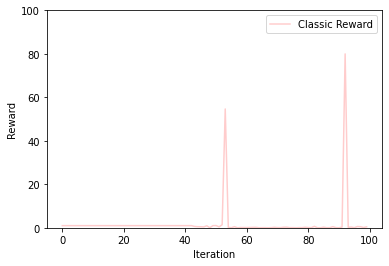

In [ ]:
import importlib
matplotlib.use('TkAgg')
matplotlib = importlib.reload(matplotlib)
%matplotlib inline
plt.ylim(0, 100)
plt.plot(c1_l, color='red', alpha=0.2, label='Classic Reward')
# plt.plot(c1_ar, color='red', label='Classic Average')
# plt.plot(q_rewards, color='blue', alpha=0.2, label='Quantum Reward')
# plt.plot(q_avg_reward, color='blue', label='Quantum Average')
plt.legend()
plt.ylabel('Reward')
plt.xlabel('Iteration')
plt.show()

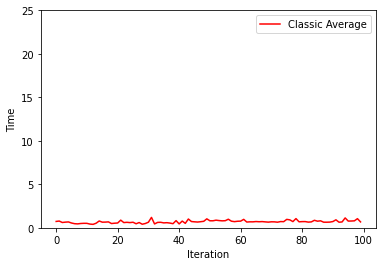

In [ ]:
plt.ylim(0, 25)
plt.plot(c1_t, color='red', label='Classic Average')
plt.legend()
plt.ylabel('Time')
plt.xlabel('Iteration')
plt.show()

In [ ]:
plt.ylim(0, 200)
plt.plot(c1_r, color='red', alpha=0.2, label='Classic Reward')
plt.plot(c1_ar, color='red', label='Classic Average')
# plt.plot(q_rewards, color='blue', alpha=0.2, label='Quantum Reward')
# plt.plot(q_avg_reward, color='blue', label='Quantum Average')
plt.legend()
plt.ylabel('Reward')
plt.xlabel('Iteration')
plt.show()

Quantum DQN with adjustable number of qubits


In [ ]:
import gym
import numpy as np
import random
import matplotlib.pyplot as plt
import math
from collections import deque
import tensorflow as tf
import tensorflow_quantum as tfq
import cirq 
import sympy
import time
import datetime # https://stackoverflow.com/questions/10607688/how-to-create-a-file-name-with-the-current-date-time-in-python
class QDQN_alt(object):
    def __init__(self, action_space, state_space, batch, no_qubits=4) -> None:
        super().__init__()
        self.action_space = action_space
        self.state_space = state_space
        self.no_qubits = no_qubits
        self.qubits = [cirq.GridQubit(0, i) for i in range(no_qubits)]
        self.q_network = self.make_func_approx()
        self.learning_rate = 0.01
        self.opt = tf.keras.optimizers.Adam(lr=self.learning_rate)
        self.buff = 10000
        self.batch = batch      
        self.states = np.zeros((self.buff, self.state_space))
        self.actions = np.zeros((self.buff, 1))
        self.rewards = np.zeros((self.buff, 1))
        self.dones = np.zeros((self.buff, 1))
        self.next_states = np.zeros((self.buff, self.state_space))
        # Q Learning
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_decay = 0.9
        self.epsilon_min = 0.01
        self.counter = 0
        self.model_name = "QDQN-{date}_qbits{q}_ADAM_lr{lr}_g{g}_eps{ep}_epsmin{epmin}_epsd{epd}".format(
            date=datetime.datetime.now().strftime("%Y-%m-%d__%H-%M-%S"),
            q=self.no_qubits,g=self.gamma, 
            lr=self.learning_rate,
            ep=self.epsilon,
            epmin=self.epsilon_min,
            epd=self.epsilon_decay)

    def make_func_approx(self):
        readout_operators = [cirq.Z(self.qubits[i]) for i in range(2,4)]
        inputs = tf.keras.Input(shape=(), dtype=tf.dtypes.string)
        diff = tfq.differentiators.ParameterShift()
        init = tf.keras.initializers.Zeros
        pqc = tfq.layers.PQC(self.make_circuit(self.qubits), readout_operators, differentiator=diff, initializer=init)(inputs)
        model = tf.keras.Model(inputs=inputs, outputs=pqc)
        return model

    def convert_data(self, classical_data, flag=True):
        ops = cirq.Circuit()
        for i, ang in enumerate(classical_data):
            ang = 0 if ang < 0 else 1
            ops.append(cirq.rx(np.pi * ang).on(self.qubits[i]))
            ops.append(cirq.rz(np.pi * ang).on(self.qubits[i]))
        if flag:
            return tfq.convert_to_tensor([ops])
        else:
            return ops

    def one_qubit_unitary(self, bit, symbols):
        return cirq.Circuit(
            cirq.X(bit)**symbols[0],
            cirq.Y(bit)**symbols[1],
            cirq.Z(bit)**symbols[2])

    def two_qubit_pool(self, source_qubit, sink_qubit, symbols):
        pool_circuit = cirq.Circuit()
        sink_basis_selector = self.one_qubit_unitary(sink_qubit, symbols[0:3])
        source_basis_selector = self.one_qubit_unitary(source_qubit, symbols[3:6])
        pool_circuit.append(sink_basis_selector)
        pool_circuit.append(source_basis_selector)
        pool_circuit.append(cirq.CNOT(control=source_qubit, target=sink_qubit))
        pool_circuit.append(sink_basis_selector**-1)
        return pool_circuit

    def make_circuit(self, qubits):
        m = cirq.Circuit()
        no_vars = self.no_qubits*3*3 + 2*6
        
        no_vars_str = "q0:"+str(no_vars)
        print(no_vars_str)
        symbols = sympy.symbols(no_vars_str) # 4 qubits * 3 weights per bit * 3 layers + 2 * 6 pooling = 36 + 12 = 48
        
        m += self.layer(symbols[:3*self.no_qubits], qubits)
        m += self.layer(symbols[3*self.no_qubits:2*3*self.no_qubits], qubits)
        m += self.layer(symbols[2*3*self.no_qubits:3*3*self.no_qubits], qubits)
        print(m)
        m += self.two_qubit_pool(self.qubits[0], self.qubits[2], symbols[3*3*self.no_qubits:3*3*self.no_qubits+6])
        m += self.two_qubit_pool(self.qubits[1], self.qubits[3], symbols[3*3*self.no_qubits+6:])
        return m
    
    def layer(self, weights, qubits):
        l = cirq.Circuit()

        for i in range(len(qubits) - 1):
            l.append(cirq.CNOT(qubits[i], qubits[i+1]))
        l.append([cirq.Moment([cirq.rx(weights[j]).on(qubits[j]) for j in range(self.no_qubits)])])
        l.append([cirq.Moment([cirq.ry(weights[j + self.no_qubits]).on(qubits[j]) for j in range(self.no_qubits)])])
        l.append([cirq.Moment([cirq.rz(weights[j + 2*self.no_qubits]).on(qubits[j]) for j in range(self.no_qubits)])])
        return l
    
    def remember(self, state, action, reward, next_state, done):
        i = self.counter % self.buff
        self.states[i] = state
        self.actions[i] = action
        self.rewards[i] = reward
        self.next_states[i] = next_state
        self.dones[i] = int(done)
        self.counter += 1

    def get_action(self, obs):
        if random.random() < self.epsilon: 
            return np.random.choice(self.action_space)
        else:
            return np.argmax(self.q_network.predict(self.convert_data(obs)))
    def train(self):
        batch_indices = np.random.choice(min(self.counter, self.buff), self.batch)
        state_batch = tfq.convert_to_tensor([self.convert_data(i, False) for i in self.states[batch_indices]])
        action_batch = tf.convert_to_tensor(self.actions[batch_indices])
        action_batch = [[i, action_batch[i][0]] for i in range(len(action_batch))]
        reward_batch = tf.convert_to_tensor(self.rewards[batch_indices])
        dones_batch = tf.convert_to_tensor(self.dones[batch_indices])
        reward_batch = tf.cast(reward_batch, dtype=tf.float32)
        action_batch = tf.cast(action_batch, dtype=tf.int32)
        dones_batch = tf.cast(dones_batch, dtype=tf.float32)
        next_state_batch = tfq.convert_to_tensor([self.convert_data(i, False) for i in self.next_states[batch_indices]])
        # loss = None
        with tf.GradientTape() as tape:
            next_q = self.q_network(next_state_batch)
            y = reward_batch + (1 - dones_batch) * self.gamma * next_q
            q_guess = self.q_network(state_batch, training=True)
            pred = tf.gather_nd(q_guess, action_batch)
            pred = tf.reshape(pred, [self.batch, 1])
            msbe = tf.math.reduce_mean(tf.math.square(y - pred))
            # loss = msbe
        grads = tape.gradient(msbe, self.q_network.trainable_variables)
        self.opt.apply_gradients(zip(grads, self.q_network.trainable_variables))
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        # return loss
import os.path
from os import path
def make_path(p, d):
  print("Checking if {} exists...".format(p+d))
  if path.exists(p+d) == False:
    print("making... new directory")
    os.mkdir(p+str(d))
  print("finished!")
  print(p+str(d))
  return p+str(d)

iterations = 60
rolling_avg = 50
learn_delay=1000
LOSSES = []
AVERAGE_LOSSES = deque(maxlen=ITERATIONS)
cur_loss = 1
env = gym.make("CartPole-v1")
agent = QDQN_alt(env.action_space.n, env.observation_space.shape[0], 32, 4)
rewards = []
avg_reward = deque(maxlen=5*iterations)
best_avg_reward = avg = -math.inf
rs = deque(maxlen=rolling_avg)
master_path = make_path("/content/drive/MyDrive/quantum_research/quantum_models/", agent.model_name)
score_logger = ScoreLogger(path=master_path, env_name="CartPole-v1")
video_filename = "{}.mp4".format(master_path+"/training_video")
epi_times=[]
start_time = time.time()

with imageio.get_writer(video_filename , fps=30) as video:
  for i in range(iterations):
      s1 = env.reset()
      epi_start = time.time()
      EPISODE_LOSSES = []
      video.append_data(env.render(mode="rgb_array"))
      total_reward = 0
      done = False
      step = 0
      while not done:
          step+=1
          action = agent.get_action(s1)
          s2, reward, done, _ = env.step(action)
          total_reward += reward
          agent.remember(s1, action, reward, s2, done)
          video.append_data(env.render(mode="rgb_array"))
          if agent.counter > learn_delay and done:
              agent.train()
              
          if done:
              rewards.append(total_reward)
              rs.append(total_reward)
              score_logger.add_score(step, i)
          else:
              s1 = s2
      avg = np.mean(rs)
      avg_reward.append(avg)
      if len(EPISODE_LOSSES)>0:
          EPISODE_LOSSES= np.asarray(EPISODE_LOSSES)
          AVERAGE_EPISODE_LOSS = np.mean(EPISODE_LOSSES)
          LOSSES.append(AVERAGE_EPISODE_LOSS)
          cur_loss = AVERAGE_EPISODE_LOSS
      else:
          LOSSES.append(cur_loss)
      if avg > best_avg_reward:
          best_avg_reward = avg
      epi_end = time.time() -epi_start
      epi_times.append(epi_end)
      print("\rEpisode {}/{} || Best average reward {}, Current Avg {}, Current Iteration Reward {}, eps {}, time {}".format(
            i, iterations, best_avg_reward, avg, total_reward, agent.epsilon, time.time()-epi_start), end='', flush=True)
  final_time = time.time()-start_time
  print("")
  print("\n final time:", final_time)
  reward_file = "{h}/rewards".format(h = master_path)
  average_file = "{h}/averages".format(h=master_path)
  times_file = "{h}/times".format(h=master_path)
  loss_file = "{h}/loss".format(h=master_path)
  np.save(reward_file , np.asarray(rewards))
  np.save(average_file , np.asarray(avg_reward))
  np.save(times_file , np.asarray(epi_times))
  np.save(loss_file , np.asarray(LOSSES))


q0:48
(0, 0): ───@───────────Rx(q0)───Ry(q4)───Rz(q8)────@───────────Rx(q12)───Ry(q16)───Rz(q20)───@───────────Rx(q24)───Ry(q28)───Rz(q32)───
           │                                       │                                         │
(0, 1): ───X───@───────Rx(q1)───Ry(q5)───Rz(q9)────X───@───────Rx(q13)───Ry(q17)───Rz(q21)───X───@───────Rx(q25)───Ry(q29)───Rz(q33)───
               │                                       │                                         │
(0, 2): ───────X───@───Rx(q2)───Ry(q6)───Rz(q10)───────X───@───Rx(q14)───Ry(q18)───Rz(q22)───────X───@───Rx(q26)───Ry(q30)───Rz(q34)───
                   │                                       │                                         │
(0, 3): ───────────X───Rx(q3)───Ry(q7)───Rz(q11)───────────X───Rx(q15)───Ry(q19)───Rz(q23)───────────X───Rx(q27)───Ry(q31)───Rz(q35)───


Checking if /content/drive/MyDrive/quantum_research/quantum_models/QDQN-2021-03-30__20-25-28_qbits4_ADAM_lr0.01_g0.95_eps1.0_epsmin0.01_epsd0.9 exists...
making... new directory
finished!
/content/drive/MyDrive/quantum_research/quantum_models/QDQN-2021-03-30__20-25-28_qbits4_ADAM_lr0.01_g0.95_eps1.0_epsmin0.01_epsd0.9
Scores: (min: 16, avg: 16, max: 16)

Episode 0/60 || Best average reward 16.0, Current Avg 16.0, Current Iteration Reward 16.0, eps 1.0, time 0.5954434871673584

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RankWarning: Polyfit may be poorly conditioned


Scores: (min: 13, avg: 14.5, max: 16)

Episode 1/60 || Best average reward 16.0, Current Avg 14.5, Current Iteration Reward 13.0, eps 1.0, time 0.4256925582885742Scores: (min: 13, avg: 17.666666666666668, max: 24)

Episode 2/60 || Best average reward 17.666666666666668, Current Avg 17.666666666666668, Current Iteration Reward 24.0, eps 1.0, time 0.5670914649963379Scores: (min: 13, avg: 17.25, max: 24)

Episode 3/60 || Best average reward 17.666666666666668, Current Avg 17.25, Current Iteration Reward 16.0, eps 1.0, time 0.4950137138366699Scores: (min: 13, avg: 16.4, max: 24)

Episode 4/60 || Best average reward 17.666666666666668, Current Avg 16.4, Current Iteration Reward 13.0, eps 1.0, time 0.4593801498413086Scores: (min: 13, avg: 20.666666666666668, max: 42)

Episode 5/60 || Best average reward 20.666666666666668, Current Avg 20.666666666666668, Current Iteration Reward 42.0, eps 1.0, time 0.7726020812988281Scores: (min: 13, avg: 20.428571428571427, max: 42)

Episode 6/60 || Best av

TypeError: ignored

In [ ]:
q1_r = rewards
q1_ar = avg_reward
q1_t = epi_times

In [ ]:
c1_r = np.load("/content/drive/MyDrive/quantum_research/classical_models/CDQN-2021-03-29_23-07-36_58_ADAM_lr0.01_g0.95_eps1.0_epsmin0.01_epsd0.9/rewards.npy")
c1_ar = np.load("/content/drive/MyDrive/quantum_research/classical_models/CDQN-2021-03-29_23-07-36_58_ADAM_lr0.01_g0.95_eps1.0_epsmin0.01_epsd0.9/averages.npy")
c1_t = np.load("/content/drive/MyDrive/quantum_research/classical_models/CDQN-2021-03-29_23-07-36_58_ADAM_lr0.01_g0.95_eps1.0_epsmin0.01_epsd0.9/times.npy")

In [ ]:
c2_r = np.load("/content/drive/MyDrive/quantum_research/classical_models/CDQN-2021-03-29_23-09-30_226_ADAM_lr0.01_g0.95_eps1.0_epsmin0.01_epsd0.9/rewards.npy")
c2_ar = np.load("/content/drive/MyDrive/quantum_research/classical_models/CDQN-2021-03-29_23-09-30_226_ADAM_lr0.01_g0.95_eps1.0_epsmin0.01_epsd0.9/averages.npy")
c2_t = np.load("/content/drive/MyDrive/quantum_research/classical_models/CDQN-2021-03-29_23-09-30_226_ADAM_lr0.01_g0.95_eps1.0_epsmin0.01_epsd0.9/times.npy")

In [ ]:
c3_r = np.load("/content/drive/MyDrive/quantum_research/classical_models/CDQN-2021-03-29_23-15-43_1282_ADAM_lr0.01_g0.95_eps1.0_epsmin0.01_epsd0.9/rewards.npy")
c3_ar = np.load("/content/drive/MyDrive/quantum_research/classical_models/CDQN-2021-03-29_23-15-43_1282_ADAM_lr0.01_g0.95_eps1.0_epsmin0.01_epsd0.9/averages.npy")
c3_t = np.load("/content/drive/MyDrive/quantum_research/classical_models/CDQN-2021-03-29_23-15-43_1282_ADAM_lr0.01_g0.95_eps1.0_epsmin0.01_epsd0.9/times.npy")

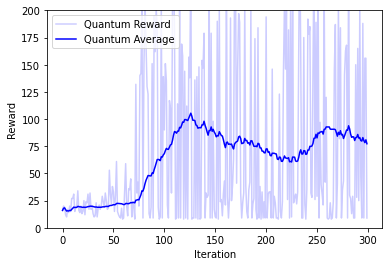

In [ ]:
import importlib
matplotlib.use('TkAgg')
matplotlib = importlib.reload(matplotlib)
%matplotlib inline
plt.ylim(0, 200)
# plt.plot(c1_r, color='red', alpha=0.2, label='Classic Reward')
# plt.plot(c1_ar, color='red', label='Classic Average')
plt.plot(q1_r, color='blue', alpha=0.2, label='Quantum Reward')
plt.plot(q1_ar, color='blue', label='Quantum Average')
plt.legend()
plt.ylabel('Reward')
plt.xlabel('Iteration')
plt.show()

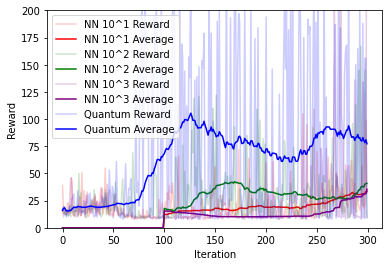

In [ ]:
plt.ylim(0, 200)
plt.plot(c1_r, color='red', alpha=0.2, label='NN 10^1 Reward ')
plt.plot(c1_ar, color='red', label='NN 10^1 Average')
plt.plot(c2_r, color='green', alpha=0.2, label='NN 10^2 Reward ')
plt.plot(c2_ar, color='green', label='NN 10^2 Average')
plt.plot(c3_r, color='purple', alpha=0.2, label='NN 10^3 Reward ')
plt.plot(c3_ar, color='purple', label='NN 10^3 Average')
plt.plot(q1_r, color='blue', alpha=0.2, label='Quantum Reward')
plt.plot(q1_ar, color='blue', label='Quantum Average')
plt.legend()
plt.ylabel('Reward')
plt.xlabel('Iteration')
plt.show()

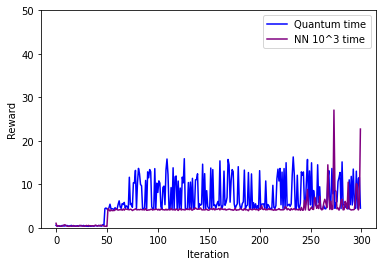

In [ ]:
plt.ylim(0,50)
# plt.plot(c1_t, color='red', label='NN 10^1 time')
plt.plot(q1_t, color='blue',  label='Quantum time')
# plt.plot(c2_t, color='green', label='NN 10^2 time')
plt.plot(c3_t, color='purple', label='NN 10^3 time')
plt.legend()
plt.ylabel('Reward')
plt.xlabel('Iteration')
plt.show()

In [ ]:
# def run_cartpole(agent, env, agent_type, 
#                  iterations,
#                  learn_delay,
#                  ):
#   rolling_avg = 50
#   epi_times = []
#   rewards = []
  
#   avg_reward = deque(maxlen=5*iterations)
#   best_avg_reward = avg = -math.inf
#   rs = deque(maxlen=rolling_avg)
#   master_path = None
#   windows = 100

#   if agent_type == "q":
#     master_path = make_path("/content/drive/MyDrive/quantum_research/quantum_models/", agent.model_name)
#   elif agent_type =="c":
#     master_path = make_path("/content/drive/MyDrive/quantum_research/classical_models/", agent.model_name)
#   score_logger = ScoreLogger(path=master_path, env_name="CartPole-v1")
#   video_filename = "{}.mp4".format(master_path+"/training_video")
  
#   if agent_type == "q":
#     epi_times = []
#     start_time = time.time()
#     with imageio.get_writer(video_filename, fps=30) as video:
#       for i in range(1,iterations+1):
#           s1 = env.reset()
#           total_reward = 0
#           done = False
#           video.append_data(env.render(mode="rgb_array"))
#           epi_time = time.time()
#           step = 0
#           while not done:
#               step+=1
#               action = agent.get_action(s1)
#               s2, reward, done, _ = env.step(action)
#               total_reward += reward
#               agent.remember(s1, action, reward, s2, done)
#               video.append_data(env.render(mode="rgb_array"))
#               if agent.counter > learn_delay and done:
#                   agent.train()
#               if done:
#                   rewards.append(total_reward)
#                   rs.append(total_reward)
#                   score_logger.add_score(step, i)
#               else:
#                   s1 = s2
#           avg = np.mean(rs)
#           avg_reward.append(avg)
#           if avg > best_avg_reward:
#               best_avg_reward = avg
#           epi_end = time.time() -epi_start
#           epi_times.append(epi_end)
#           print("\rEpisode {}/{} || Best average reward {}, Current Avg {}, Current Iteration Reward {}, eps {}, time {}".format(
#               i, iterations, best_avg_reward, avg, total_reward, agent.epsilon, time.time()-epi_time), end='', flush=True)
#       final_time = time.time()-start_time 
#       print("\n final time:", final_time)
#       reward_file = "{h}/rewards".format(h = master_path)
#       average_file = "{h}/averages".format(h=master_path)
#       times_file = "{h}/times".format(h=master_path)
#       np.save(reward_file , np.asarray(rewards))
#       np.save(average_file , np.asarray(avg_reward))
#       np.save(times_file , np.asarray(episode_times))
#       return rewards, avg_reward, epi_times
#   elif agent_type == "c":
#     print("yay")
#     epi_times = []
#     start_time = time.time()
#     with imageio.get_writer(video_filename, fps=30) as video:
#       start_time = time.time()
#       for i in range(1,iterations+1):
#           s1 = env.reset()
#           epi_start = time.time()
#           video.append_data(env.render(mode="rgb_array"))
#           total_reward = 0
#           done = False
#           step = 0
#           while not done:
#               step +=1
#               action = agent.get_action(s1)
#               s2, reward, done, info = env.step(action)
#               total_reward += reward
#               agent.remember(s1, action, reward, s2, done)
#               video.append_data(env.render(mode="rgb_array"))
#               if len(agent.memory) > learn_delay and done:
#                   agent.train()    
#               if done:
#                   rewards.append(total_reward)
#                   rs.append(total_reward)
#                   score_logger.add_score(step, i)
#               else:
#                   s1 = s2
#           if i >= windows:
#               avg = np.mean(rs)
#               avg_reward.append(avg)
#               if avg > best_avg_reward:
#                   best_avg_reward = avg
#                   weight_name = "{h}/model.h5".format(h = master_path)
#                   agent.q_network.save(weight_name)
#           else: 
#               avg_reward.append(0)
#           epi_end = time.time() -epi_start
#           epi_times.append(epi_end)
#           print("\rEpisode {}/{} || Best average reward {}, Current Iteration Reward {}, Current Runtime {}".format(
#               i, iterations, best_avg_reward, total_reward, epi_end) , end='', flush=True)
#       print("total runtime:", time.time()-start_time)
#       reward_file = "{h}/rewards".format(h = master_path)
#       average_file = "{h}/averages".format(h=master_path)
#       times_file = "{h}/times".format(h=master_path)
#       np.save(reward_file , np.asarray(rewards))
#       np.save(average_file , np.asarray(avg_reward))
#       np.save(times_file , np.asarray(epi_times))
#       return rewards, avg_reward, epi_times

In [ ]:
# env1 = gym.make("CartPole-v1")
# env2 = gym.make("CartPole-v1")
# c_agent = CDQN(env1.action_space.n, env1.observation_space.shape[0], 32) 
# q_agent = QDQN_alt(env2.action_space.n, env2.observation_space.shape[0], 32, 4)


q0:48
(0, 0): ───@───────────Rx(q0)───Ry(q4)───Rz(q8)────@───────────Rx(q12)───Ry(q16)───Rz(q20)───@───────────Rx(q24)───Ry(q28)───Rz(q32)───
           │                                       │                                         │
(0, 1): ───X───@───────Rx(q1)───Ry(q5)───Rz(q9)────X───@───────Rx(q13)───Ry(q17)───Rz(q21)───X───@───────Rx(q25)───Ry(q29)───Rz(q33)───
               │                                       │                                         │
(0, 2): ───────X───@───Rx(q2)───Ry(q6)───Rz(q10)───────X───@───Rx(q14)───Ry(q18)───Rz(q22)───────X───@───Rx(q26)───Ry(q30)───Rz(q34)───
                   │                                       │                                         │
(0, 3): ───────────X───Rx(q3)───Ry(q7)───Rz(q11)───────────X───Rx(q15)───Ry(q19)───Rz(q23)───────────X───Rx(q27)───Ry(q31)───Rz(q35)───


In [ ]:
# c_r, c_ar, c_t = run_cartpole(c_agent, env1, "c", 300, 1000)

In [ ]:
# q_r, q_ar, q_t = run_cartpole(q_agent, env2, "q", 300, 1000)

Checking if /content/drive/MyDrive/quantum_research/quantum_models/QDQN-2021-03-27__16-47-11_qbits4_ADAM_lr0.01_g0.99_eps1.0_epsmin0.01_epsd0.9 exists...
making... new directory
finished!
/content/drive/MyDrive/quantum_research/quantum_models/QDQN-2021-03-27__16-47-11_qbits4_ADAM_lr0.01_g0.99_eps1.0_epsmin0.01_epsd0.9


Scores: (min: 17, avg: 17, max: 17)



UnboundLocalError: ignored

In [ ]:
plt.ylim(0, 200)
plt.plot(c_r, color='red', alpha=0.2, label='Classic Reward')
plt.plot(c_ar, color='red', label='Classic Average')
plt.plot(q_r, color='blue', alpha=0.2, label='Quantum Reward')
plt.plot(q_ar, color='blue', label='Quantum Average')
plt.legend()
plt.ylabel('Reward')
plt.xlabel('Iteration')
plt.show()